# Linear elasticity

## Review of the formulation

Linear elastic bodies are caracterized by a quadratic strain energy density function 

$$w(\varepsilon)=\frac{1}{2} \mathbb{C} \,(\varepsilon-\varepsilon_0)\cdot (\varepsilon-\varepsilon_0)$$
where

-  $\varepsilon$ is the second order (symmetric) strain tensor
- $\varepsilon_0$ is the inelastic strain (e.g. for thermal strain in isotropic materials $\varepsilon_0=-\alpha \Delta T$
- $\mathbb{C}$ is the forth order elastic tensor.

The (symmetric) stress tensor is defined as 
$$
\sigma(\varepsilon) = \dfrac{\partial w(\varepsilon)}{\partial \varepsilon}
$$
For isotropic materials denoting by $\lambda$ and $\mu$ are the Lamé moduli.

$$
w(\varepsilon) = \frac{\lambda}{2} (\mathrm{tr}(\varepsilon-\varepsilon_0))^2+\mu \Vert\varepsilon-\varepsilon_0\Vert^2, 
\qquad 
\sigma(\varepsilon)={\lambda}\,\mathrm{tr}(\varepsilon-\varepsilon_0)+2\mu (\varepsilon-\varepsilon_0)
$$

The strain is given in therm of the displacement by $$ \varepsilon(u)=\mathrm{sym}(\nabla u)=\dfrac{\nabla u+\nabla u^T}{2}$$
Note that here $u,v$ are vector fields in $\mathcal R^2$ or $\mathcal R^3$.

Considering a body $\Omega$ submitted to body forces $b$ surface, traction $f$ on $\partial_f \Omega$, applied displacements $\bar u$ on $\partial_u\Omega$, and inelastic strain $\varepsilon_0$, the  weak formulation is: 

Find a *trial function* $u\in V$, $u=\bar u$ on $\partial_u\Omega$, such that for each *test function* in $v\in V$, $v=0$ on $\partial_u\Omega$: 

$$
a(u,v) = l(v)
$$
where 
$$a(u,v)=\int_\Omega \sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x, \quad \ell(v)=\int_\Omega b\cdot v\, \mathrm{d}x+\int_{\partial_f \Omega} f\cdot v$$

**Exercices:**

1. Show that the weak formulation above coincides with the stationarity condition of the following minimization problem for the potential energy $\mathcal E(u)$
$$
\min_{u\in V, \, u=\bar u \text{ on } \partial_u\Omega}\mathcal E(u),\qquad \mathcal E(u)=\dfrac{1}{2}a(u,u) - l(v)
$$
2. Show that the weak formulation above is equivalent to the classical equation of linear elasticity in the strong form with the associated Dirichlet et Neumann boundary conditions
3. Show by dimensional analysis that, without loss of generality, one can set, up to a rescaling of the variables, $L:=\vert\Omega\vert=1$ and $\lambda=1$ when performing numerical computations

# Finite element solution (with FEniCS)

We will solve now the classical problem of the traction of plate with an hole (in plane-strain)

From now on I will import fenics in the main namespace

In [2]:
import dolfin
import numpy as np
import mshr
import matplotlib.pyplot as plt

I use [mshr](https://bitbucket.org/fenics-project/mshr) to make a mesh with an hole using. A good alternative is [gmsh](http://gmsh.info): you can do your mesh, save to file, convert to fenics format using [meshio](https://github.com/nschloe/meshio) and load in fenics from file.

# Mesh

type de cellule :  triangle


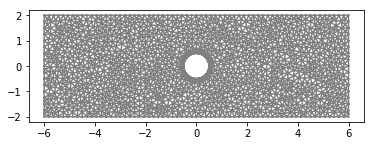

In [7]:
xmin, xmax = -6., 6.
ymin, ymax = -2., 2.
radius = 0.5
n = 40
p0 = dolfin.Point(xmin, ymin)
p1 = dolfin.Point(xmax, ymax)
c = dolfin.Point(0.,0.)

square = mshr.Rectangle(p0,p1)

hole = mshr.Circle(c,radius,2*n)

geom = square - hole
mesh = mshr.generate_mesh(geom,n)
dolfin.plot(mesh)
print('type de cellule : ',mesh.ufl_cell())

# Function space

In [8]:
V = dolfin.VectorFunctionSpace(mesh, 'P',1)

In [9]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

# Variational formulation

In [10]:
# Elasticity parameters
E = dolfin.Constant(10) # Young
nu = dolfin.Constant(0.3) # Poisson
mu = E/(2*(1.0 + nu)) # lame 1 (plain strain)
lmbda = E*nu/((1.0 + nu)*(1.0 -2.0*nu)) # lame 2 (plain strain)

In [11]:
# eps = 1/2 { grad u + (grad u)^T }
def eps(u):
    return dolfin.sym(dolfin.grad(u))

In [12]:
#Hook's law
def sigma(epsilon):
    return  2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(2)

$$a(u,v)=\int_\Omega \sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x$$

In [13]:
# bilinear form
a = dolfin.inner(sigma(eps(u)), eps(v))*dolfin.dx 

$$\quad \ell(v)=\int_\Omega b\cdot v\, \mathrm{d}x+\int_{\partial_f \Omega} f\cdot v$$

In [16]:
# Bulk load 
b = dolfin.Constant((0.,0.))
L1 = dolfin.inner(b,v)*dolfin.dx

In [58]:
# external tension applied on right end side
# on va suivre tout le bord du domain, et seulement 
#                         quand x > xmin-1E-10 on met une intensite
f = dolfin.Expression(('x[0] < x_right ? 0.0 : intensity', '0.0'),
                             x_right=xmin-1E-10, intensity=0.001, degree=1)
# pour changer l'intensite : faire 'f.intensity=2'
L2 = dolfin.dot(f, v)*dolfin.ds

In [34]:
# linear form
L=L1+L2

# Boundary conditions

In [35]:
tol = 1E-14
left = dolfin.CompiledSubDomain("near(x[0], xmin, tol) && on_boundary",
                                xmin=xmin,tol=tol)
#def left(x, on_boundary):           # exactement pareil qu'au dessus
#    return on_boundary and np.abs(x[0]-xmin) <= tol

In [36]:
right = dolfin.CompiledSubDomain("near(x[0], xmax, tol) && on_boundary",
                                 xmax=xmax,tol=tol)

In [37]:
# Boundary conditions
bc_left = dolfin.DirichletBC(V, (0.,0.), left)
#bc_right = # pas de condition a droite, on a mis une force de tension
bcs = [bc_left]

# On resoud le probleme

In [38]:
usol = dolfin.Function(V)

In [55]:
f.intensity=0.08

In [56]:
dolfin.solve(a == L, usol, bcs)

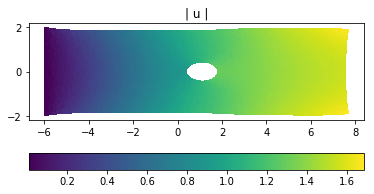

In [57]:
plt.colorbar(
    dolfin.plot(4*usol, 
                mode="displacement",
                title=r"| u |"
                ),
    orientation="horizontal")